In [4]:
import re
with open("time1.txt","r") as f:
    time = f.read()
row_list = time.split("\n")
pat = re.compile("time: (\d+.\d+)")
total_time = 0
for i in row_list:
    total_time += float(pat.findall(i)[0])
total_time += 71.17
(total_time / 3600)

1.864672222222223

In [3]:
import pickle as pkl
import sys
import os
sys.path.append("..")
from datatool import train_test_val_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from model import BertEncoder, BertPooler,BertConfig,Encoder
from lc_model import LinearRegression
from lc_tool import setup_logger,setup_seed,getGrad,adjust_learning_rate
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import argparse
import logging
import matplotlib.pyplot as plt


def fit(x,encoder,decoder,device,hist_len=6):
    encoderInput = x[:,:,:hist_len,:].float().to(device)
    encoderOutput,lastEncoderHiddenState,attention = encoder(encoderInput)
    decoderInput = lastEncoderHiddenState.squeeze(0)
    decoderOutput = decoder(decoderInput)
    return decoderOutput, attention

def predict(sample,encoder,decoder,device):
    encoder.eval()
    decoder.eval()
    sample = sample.view(1,*sample.shape)
    decoderOutput,attention = fit(sample,encoder,decoder,device)
    predict_result = torch.max(decoderOutput, 1)[1].data.cpu().numpy().squeeze()
    return predict_result, attention.reshape(6,attention.shape[2],attention.shape[3])

def plot_attention(att):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(att)
    plt.yticks(np.arange(att.shape[0]))
    plt.xticks(np.arange(att.shape[1]))
    return fig

def plot_batch(one_batch,figsize=(10,10),alpha=0.5):
    fig = plt.figure(figsize=figsize)
    for i, seq in enumerate(one_batch):
        mask = (seq!=0)
        if mask.sum()==0:
            continue      
        hist_seq,fut_seq = seq[:6],seq[6:]
        if i == 0:
            plt.scatter(hist_seq[:,0],hist_seq[:,1],c="orange",label="hist",lw=3)
            plt.scatter(fut_seq[:,0],fut_seq[:,1],c="green",label="future",lw=3,ls='--')
#             plt.gca().add_patch(patches.Rectangle((seq[5,0]-10, seq[5,1]-0.05), 10, 0.1,edgecolor="black",facecolor="orange"))
            plt.text(x= seq[5,0]-5, y = seq[5,1]-0.5,s=f"{i}",fontsize=12,fontweight="bold", horizontalalignment='center')
        elif i == 1:
            hist_mask,fut_mask = (hist_seq!=0),(fut_seq!=0)
            mhist_seq = hist_seq[hist_mask].reshape(-1,2)
            mfut_seq = fut_seq[fut_mask].reshape(-1,2)  
            # plot hist
            if hist_mask.sum()==0:
                pass
            else:
                plt.scatter(mhist_seq[:,0],mhist_seq[:,1],c="blue",label="neighbor hist",alpha=alpha+0.3,lw=3)
            # plot future
            if fut_mask.sum()==0:
                pass
            else:
                plt.scatter(mfut_seq[:,0],mfut_seq[:,1],c="blue",label="neighbor future",alpha=alpha,lw=3,ls='--')
                plt.text(x= mfut_seq[0,0]-5, y = mfut_seq[0,1]-0.5,s=f"{i}",fontsize=12,fontweight="bold", horizontalalignment='center')
            #plot current
            if (seq[5]!=0).all():
                pass
#                 plt.gca().add_patch(patches.Rectangle((seq[5,0]-10, seq[5,1]-0.05), 10, 0.1,edgecolor="black",facecolor="blue"))
#                 plt.text(x= seq[5,0]-5, y = seq[5,1]-0.5,s=f"{i}",fontsize=12,fontweight="bold", horizontalalignment='center')
        else:
            hist_mask,fut_mask = (hist_seq!=0).any(axis=1),(fut_seq!=0).any(axis=1)
            mhist_seq = hist_seq[hist_mask].reshape(-1,2)
            mfut_seq = fut_seq[fut_mask].reshape(-1,2)  
            # plot hist
            if hist_mask.sum()==0:
                pass
            else:
                plt.scatter(mhist_seq[:,0],mhist_seq[:,1],c="blue",alpha=alpha+0.3,lw=3)
            # plot future
            if fut_mask.sum()==0:
                pass
            else:
                plt.scatter(mfut_seq[:,0],mfut_seq[:,1],c="blue",alpha=alpha,lw=3,ls='--')
                plt.text(x= mfut_seq[0,0]-5, y = mfut_seq[0,1]-0.5,s=f"{i}",fontsize=12,fontweight="bold", horizontalalignment='center')
            #plot current
            if (seq[5]!=0).all():
                pass
#                 plt.gca().add_patch(patches.Rectangle((seq[5,0]-10, seq[5,1]-0.05), 10, 0.1,edgecolor="black",facecolor="blue"))
#                 plt.text(x= seq[5,0]-5, y = seq[5,1]-0.5,s=f"{i}",fontsize=12,fontweight="bold", horizontalalignment='center')
    plt.legend(loc="best")
    return fig
    


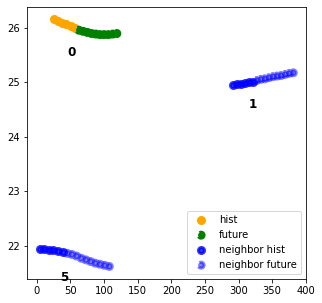

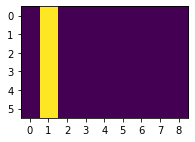

In [4]:
# xy-version

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BS = 256
SEED = 10
setup_seed(SEED)
conf_json = {
        "hidden_size":32,
        "num_hidden_layers":1,
        "num_attention_heads":1,
        "intermediate_size":32*4,
        "hidden_act":"gelu",
        "hidden_dropout_prob":0,
        "attention_probs_dropout_prob":0
    }
config = BertConfig()
config = config.from_dict(conf_json)
encoder = Encoder(config).to(DEVICE)
decoder = LinearRegression(conf_json['hidden_size']).to(DEVICE)
encoder.load_state_dict(torch.load('model/encoder_sd-10_lr-0.0001_wd-5e-05_maxep-100_bs-256_opt-adam_clip-5.0202118234833480.pkl'))
decoder.load_state_dict(torch.load('model/decoder_sd-10_lr-0.0001_wd-5e-05_maxep-100_bs-256_opt-adam_clip-5.0202118234833480.pkl'))


with open("new_data/total.pkl","rb") as f:
    data = pkl.load(f)
right_data, left_data, keep_data = data['right'], data['left'], data['keep']
keep_label = torch.zeros(keep_data.shape[0])
keepDataset = TensorDataset(torch.from_numpy(keep_data),keep_label)

i= 15500
sample_data = keepDataset[i][0]
sample_label = keepDataset[i][1]
plot_batch(sample_data,figsize=(5,5))
predict_result, attention = predict(sample_data,encoder,decoder,DEVICE)
att = attention[:,0,:]

plot_attention(att)
plt.show()

torch.Size([30, 17, 2])


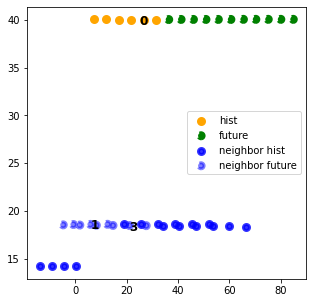

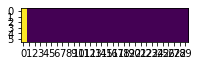

In [11]:
import h5py
class Encoder(nn.Module):
    def __init__(self,config):
        super(Encoder, self).__init__()
        self.config = config
#         self.bn = Mask_BN()
        self.embedding = nn.Linear(12,self.config.hidden_size, bias=False)
        self.encoder = BertEncoder(self.config)
        self.pooler = BertPooler(self.config)
        self.gru = nn.GRU(self.config.hidden_size,self.config.hidden_size,batch_first=True)
        self.output = nn.Linear(self.config.hidden_size,10)
    def forward(self,x):
        batchsize,vnum,seqlen,featsize = x.shape[0],x.shape[1],x.shape[2],x.shape[3]
#         m =(x.transpose(1, 2).reshape(-1,vnum,featsize)!=0).any(axis=2)*1
#         x = self.bn(x)
        x_3d = x.transpose(1, 2)
        x_3d = x_3d.reshape(-1,vnum,featsize)
        x_centralization = x_3d - (x_3d!=0)*(x_3d[:,0,:].unsqueeze(1))
        x_emb = self.embedding(x_3d)
        m = (x_emb!=0).any(axis=2)*1
        attention_mask = m.unsqueeze(1).unsqueeze(2)# wzz
        attention_mask = (1.0 - attention_mask) * -10000.0
        encoded_outputs,attention = self.encoder(x_emb,attention_mask,get_attention_matrices=True)
        encoded_output = self.pooler(encoded_outputs[-1])
        encoded_output = encoded_output.reshape(batchsize,seqlen,self.config.hidden_size)
        encoded_output,last_encoded_output = self.gru(encoded_output)
        return encoded_output,last_encoded_output,attention[0].data.cpu().numpy()


def predict(sample,encoder,decoder,device):
    encoder.eval()
    decoder.eval()
    sample = sample.view(1,*sample.shape)
    decoderOutput,attention = fit(sample,encoder,decoder,device)
    predict_result = torch.max(decoderOutput, 1)[1].data.cpu().numpy().squeeze()
    return predict_result, attention.reshape(6,attention.shape[2],attention.shape[3])

def plot_attention(att):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(att)
    plt.yticks(np.arange(att.shape[0]))
    plt.xticks(np.arange(att.shape[1]))
    return fig

with h5py.File("../pickle_data/salstm_combine_feature_12_dim.hdf5","r") as f:
    right_data = f['right_data'][()]
    left_data = f['left_data'][()]
    keep_data = f['keep_data'][()]

keep_label = torch.zeros(keep_data.shape[0])
keepDataset = TensorDataset(torch.from_numpy(keep_data),keep_label)

i= 15500
sample_data = keepDataset[i][0][:,:,:2]
print(sample_data.shape)
sample_label = keepDataset[i][1]
plot_batch(sample_data,figsize=(5,5))
predict_result, attention = predict(sample_data,encoder,decoder,DEVICE)
att = attention[:,0,:]

plot_attention(att)
plt.show()

In [127]:
for i in range(0,right_data.shape[0],40):
    sample_data = rightDataset[i][0]
    sample_label = rightDataset[i][1]
    plot_batch(sample_data,figsize=(5,5))
    plt.savefig(f"temp/right_pic/{i}_track.png")
    predict_result, attention = predict(sample_data,encoder,decoder,DEVICE)
    att1 = attention[:,0,:]
    plot_attention(att1)
    plt.savefig(f"temp/right_pic/{i}_att_1.png")
#     att2 = attention[:,:,0]
#     plot_attention(att2)
#     plt.savefig(f"temp/right_pic/{i}_att_2.png")
    plt.close("all")